<a href="https://colab.research.google.com/github/arthurnicolas59/BloodCellDec22---DataScientest/blob/Ludo/7_Comparatif_Mod%C3%A8les_de_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connexion au drive et import des modules**

In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np
import os
import glob
import cv2
from keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.applications import VGG16
from keras.layers import Multiply, Flatten, Dense, Input
from keras.models import Model
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# **1. Préparation des données de synthèse**

## **1.1. Construction du dataframe 'df_fusion' présentant les chemins d'accès à l'ensemble des images traitées et non traitées**

In [4]:
# Import
!unzip 'drive/MyDrive/Datascientest/Images_masquees_19082023.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: fusion/neutrophil/BNE_44875_fusion.png  
  inflating: fusion/neutrophil/BNE_448776_fusion.png  
  inflating: fusion/neutrophil/BNE_449730_fusion.png  
  inflating: fusion/neutrophil/BNE_449915_fusion.png  
  inflating: fusion/neutrophil/BNE_450464_fusion.png  
  inflating: fusion/neutrophil/BNE_451701_fusion.png  
  inflating: fusion/neutrophil/BNE_451729_fusion.png  
  inflating: fusion/neutrophil/BNE_453088_fusion.png  
  inflating: fusion/neutrophil/BNE_454089_fusion.png  
  inflating: fusion/neutrophil/BNE_454943_fusion.png  
  inflating: fusion/neutrophil/BNE_455080_fusion.png  
  inflating: fusion/neutrophil/BNE_4555_fusion.png  
  inflating: fusion/neutrophil/BNE_455636_fusion.png  
  inflating: fusion/neutrophil/BNE_45575_fusion.png  
  inflating: fusion/neutrophil/BNE_456543_fusion.png  
  inflating: fusion/neutrophil/BNE_45687_fusion.png  
  inflating: fusion/neutrophil/BNE_45719_fusion

In [21]:
# Trouver tous les chemins vers les fichiers qui finissent par .png
liste_fusion = glob.glob('/content/fusion/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_fusion = list(map(lambda x : [
    '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg',
    '/content/Images_egalisees/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg',
    '/content/images_egalisation_adaptative/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg',
    x,
    x.split('/')[4].split('_')[0]],
    liste_fusion))

# Créer un DataFrame pandas
df_fusion = pd.DataFrame(liste_fusion, columns=['filepath','egalisation_path','egalisation_adaptative_path','fusionpath','nameLabel'])
df_fusion=df_fusion.replace(['SNE','BNE'],'NEUTROPHIL')
df_fusion=df_fusion.replace(['MY','MMY','PMY'],'IG')
df_fusion.sort_values('fusionpath')
df_fusion

,filepath,egalisation_path,egalisation_adaptative_path,fusionpath,nameLabel
0,/content/PBC_dataset_normal_DIB/lymphocyte/LY_...,/content/Images_egalisees/lymphocyte/LY_644595...,/content/images_egalisation_adaptative/lymphoc...,/content/fusion/lymphocyte/LY_644595_fusion.png,LY
1,/content/PBC_dataset_normal_DIB/lymphocyte/LY_...,/content/Images_egalisees/lymphocyte/LY_707113...,/content/images_egalisation_adaptative/lymphoc...,/content/fusion/lymphocyte/LY_707113_fusion.png,LY
2,/content/PBC_dataset_normal_DIB/lymphocyte/LY_...,/content/Images_egalisees/lymphocyte/LY_715395...,/content/images_egalisation_adaptative/lymphoc...,/content/fusion/lymphocyte/LY_715395_fusion.png,LY
3,/content/PBC_dataset_normal_DIB/lymphocyte/LY_...,/content/Images_egalisees/lymphocyte/LY_789385...,/content/images_egalisation_adaptative/lymphoc...,/content/fusion/lymphocyte/LY_789385_fusion.png,LY
4,/content/PBC_dataset_normal_DIB/lymphocyte/LY_...,/content/Images_egalisees/lymphocyte/LY_586473...,/content/images_egalisation_adaptative/lymphoc...,/content/fusion/lymphocyte/LY_586473_fusion.png,LY
...,...,...,...,...,...
17087,/content/PBC_dataset_normal_DIB/monocyte/MO_23...,/content/Images_egalisees/monocyte/MO_237869.jpg,/content/images_egalisation_adaptative/monocyt...,/content/fusion/monocyte/MO_237869_fusion.png,MO
17088,/content/PBC_dataset_normal_DIB/monocyte/MO_40...,/content/Images_egalisees/monocyte/MO_409354.jpg,/content/images_egalisation_adaptative/monocyt...,/content/fusion/monocyte/MO_409354_fusion.png,MO
17089,/content/PBC_dataset_normal_DIB/monocyte/MO_81...,/content/Images_egalisees/monocyte/MO_812962.jpg,/content/images_egalisation_adaptative/monocyt...,/content/fusion/monocyte/MO_812962_fusion.png,MO
17090,/content/PBC_dataset_normal_DIB/monocyte/MO_98...,/content/Images_egalisees/monocyte/MO_985517.jpg,/content/images_egalisation_adaptative/monocyt...,/content/fusion/monocyte/MO_985517_fusion.png,MO


## **1.2. Séparation du jeu de données**

In [22]:
# Diviser le dataframe en ensembles d'entraînement, de validation et de test
train_df, test_df = train_test_split(df_fusion, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

## **1.3. Définition d'une fonction pour la mise en page des matrices de confusion**

In [14]:
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, classification_report

#Création d'une Matrice de confusion
def plot_matrix(y_true, y_pred, label):
  cm = confusion_matrix(y_true.classes, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
  print('Vous retrouverez la matrice de confusion du modèle ci-dessous:')
  plt.figure()
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  print('\nVous retrouverez le rapport de classification du modèle ci-dessous:\n')
  print(classification_report(y_true.classes, y_pred, target_names=label))

## **1.4. Préparation du dataframe 'resultat_df' qui intègrera les performances des modèles de prédiction testés**

In [8]:
columns = ['Model Name','Number of Params','Accuracy','Recall','Precision','F1_score']
resultat_df = pd.DataFrame(columns = columns)
resultat_df

,Model Name,Number of Params,Accuracy,Recall,Precision,F1_score


Création d'une fonction permettant d'ajouter les résultats d'un modèle au dataframe 'resultat_df'

In [9]:
def ajout_dataframe(nom_model, y_true, y_pred, num_params, dataframe):
  accuracy= []
  recall =[]
  precision = []
  f1 = []

  model_names = nom_model
  accuracy.append(round(accuracy_score(y_true.classes, y_pred),4))
  recall.append(round(recall_score(y_true.classes, y_pred, average='macro'),4))
  precision.append(round(precision_score(y_true.classes, y_pred, average='macro'),4))
  f1.append(round(f1_score(y_true.classes, y_pred, average='macro'),4))

  result_model = {'Model Name': model_names,'Number of Params': num_params,'Accuracy':accuracy,'Recall':recall, 'Precision':precision, 'F1_score': f1}
  dataframe = dataframe.append(result_model, ignore_index=True)
  return dataframe

# **2. Prédictions des modèles**

## **2.1. Modèle Benchmark images brutes**

### **Chargement des données**

In [10]:
# image originale
!unzip -q 'drive/MyDrive/Datascientest/PBC_dataset_normal_DIB.zip' > /dev/null 2>&1

#suppression d'une image corrompue
import os

os.remove('/content/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg')

### **Génération des données d'entrainement et de test**

In [11]:
datagen_train = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = 1./255)

batch_size = 32
height  = 224 # taille adaptée à VGG16
width = 224
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='filepath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='filepath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col='filepath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False)



nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples

label_map = train_set.class_indices

print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 8751 validated image filenames belonging to 8 classes.
Found 2187 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 8751 images appartenant à 8 classes
le dataframe validation est composé de 2187 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


### **Chargement du modèle**

In [12]:
#Chargement du modèle Benchmark images brutes
model_benchmark_images_brutes = tf.keras.models.load_model('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_benchmark_images_brutes.h5')

### **Prédictions sur le jeu test**

In [13]:
#Prediction Modele Benchmark images brutes
pred_benchmark_images_brutes = model_benchmark_images_brutes.predict(test_set)
y_pred_benchmark_images_brutes = tf.argmax(pred_benchmark_images_brutes, axis = 1)

107/107 [==============================] - 13s 57ms/step


### **Matrice de confusion**

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

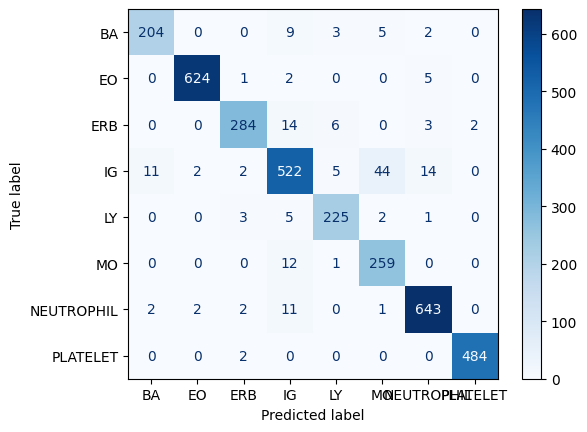


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

          BA       0.94      0.91      0.93       223
          EO       0.99      0.99      0.99       632
         ERB       0.97      0.92      0.94       309
          IG       0.91      0.87      0.89       600
          LY       0.94      0.95      0.95       236
          MO       0.83      0.95      0.89       272
  NEUTROPHIL       0.96      0.97      0.97       661
    PLATELET       1.00      1.00      1.00       486

    accuracy                           0.95      3419
   macro avg       0.94      0.95      0.94      3419
weighted avg       0.95      0.95      0.95      3419



In [15]:
plot_matrix(y_true = test_set, y_pred = y_pred_benchmark_images_brutes,label =label_map)

### **Intégration des résultats au dataframe de synthèse 'resultat_df'**

In [16]:
resultat_df=ajout_dataframe(nom_model = 'model_benchmark_images_brutes', y_true = test_set, y_pred = y_pred_benchmark_images_brutes, num_params = 16613544, dataframe = resultat_df)


<ipython-input-9-d8eadf42cf35>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(result_model, ignore_index=True)


## **2.2. Modèle Benchmark images égalisées**

### **Chargement des données**

In [17]:
# image égalisées
!unzip -q 'drive/MyDrive/Datascientest/images_equalized_2208.zip'

### **Génération des données d'entrainement et de test**

In [23]:
datagen_train = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = 1./255)

batch_size = 32
height  = 224 # taille adaptée à VGG16
width = 224
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='egalisation_path',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='egalisation_path',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col='egalisation_path',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False)



nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples

label_map = train_set.class_indices

print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 8751 validated image filenames belonging to 8 classes.
Found 2187 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 8751 images appartenant à 8 classes
le dataframe validation est composé de 2187 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


### **Chargement du modèle**

In [25]:
#Chargement du modèle Benchmark images égalisées
model_benchmark_images_egalisees = tf.keras.models.load_model('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_benchmark_images_egalisees.h5')

### **Prédictions sur le jeu test**

In [26]:
#Prediction Modele Benchmark images egalisees
pred_benchmark_images_egalisees = model_benchmark_images_egalisees.predict(test_set)
y_pred_benchmark_images_egalisees = tf.argmax(pred_benchmark_images_egalisees, axis = 1)

107/107 [==============================] - 5s 46ms/step


### **Matrice de confusion**

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

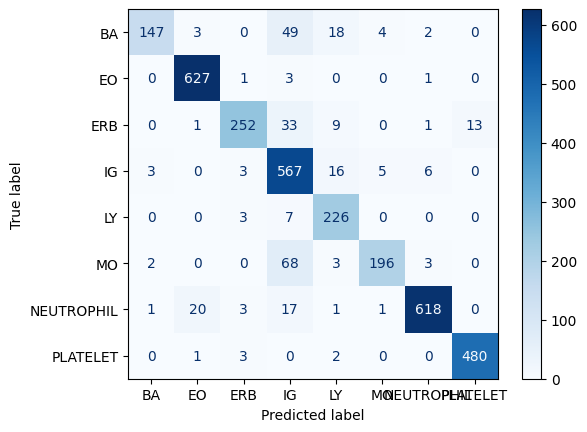


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

          BA       0.96      0.66      0.78       223
          EO       0.96      0.99      0.98       632
         ERB       0.95      0.82      0.88       309
          IG       0.76      0.94      0.84       600
          LY       0.82      0.96      0.88       236
          MO       0.95      0.72      0.82       272
  NEUTROPHIL       0.98      0.93      0.96       661
    PLATELET       0.97      0.99      0.98       486

    accuracy                           0.91      3419
   macro avg       0.92      0.88      0.89      3419
weighted avg       0.92      0.91      0.91      3419



In [27]:
plot_matrix(y_true = test_set, y_pred = y_pred_benchmark_images_egalisees,label =label_map)

### **Intégration des résultats au dataframe de synthèse 'resultat_df'**

In [28]:
resultat_df=ajout_dataframe(nom_model = 'model_benchmark_images_egalisees', y_true = test_set, y_pred = y_pred_benchmark_images_egalisees, num_params = 16613544, dataframe = resultat_df)

<ipython-input-9-d8eadf42cf35>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(result_model, ignore_index=True)


## **2.3. Modèle Benchmark images egalisation adaptative**

### **Chargement des données**

In [29]:
# image égalisées
!unzip -q 'drive/MyDrive/Datascientest/images_egalisation_adaptative_2508.zip'

### **Génération des données d'entrainement et de test**

In [30]:
datagen_train = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = 1./255)

batch_size = 32
height  = 224 # taille adaptée à VGG16
width = 224
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='egalisation_adaptative_path',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='egalisation_adaptative_path',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col='egalisation_adaptative_path',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False)



nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples

label_map = train_set.class_indices

print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 8751 validated image filenames belonging to 8 classes.
Found 2187 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 8751 images appartenant à 8 classes
le dataframe validation est composé de 2187 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


### **Chargement du modèle**

In [31]:
#Chargement du modèle Benchmark images égalisation adaptative
model_benchmark_egalisation_adaptative = tf.keras.models.load_model('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_benchmark_images_egalisation_adaptative.h5')

### **Prédictions sur le jeu test**

In [32]:
#Prediction Modele Benchmark images egalisation adaptative
pred_benchmark_egalisation_adaptative = model_benchmark_egalisation_adaptative.predict(test_set)
y_pred_benchmark_egalisation_adaptative = tf.argmax(pred_benchmark_egalisation_adaptative, axis = 1)

107/107 [==============================] - 6s 57ms/step


### **Matrice de confusion**

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

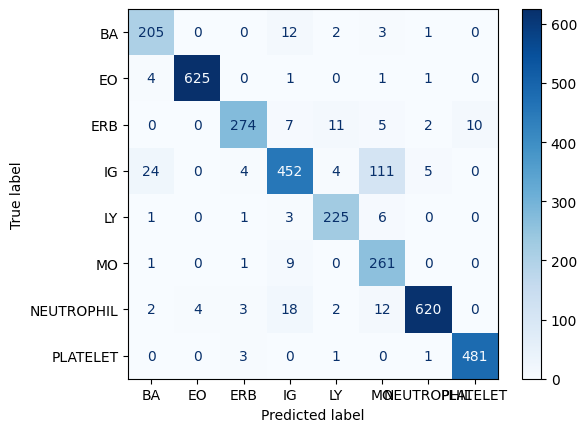


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

          BA       0.86      0.92      0.89       223
          EO       0.99      0.99      0.99       632
         ERB       0.96      0.89      0.92       309
          IG       0.90      0.75      0.82       600
          LY       0.92      0.95      0.94       236
          MO       0.65      0.96      0.78       272
  NEUTROPHIL       0.98      0.94      0.96       661
    PLATELET       0.98      0.99      0.98       486

    accuracy                           0.92      3419
   macro avg       0.91      0.92      0.91      3419
weighted avg       0.93      0.92      0.92      3419



In [33]:
plot_matrix(y_true = test_set, y_pred = y_pred_benchmark_egalisation_adaptative,label =label_map)

### **Intégration des résultats au dataframe de synthèse 'resultat_df'**

In [34]:
resultat_df=ajout_dataframe(nom_model = 'model_benchmark_egalisation_adaptative', y_true = test_set, y_pred = y_pred_benchmark_egalisation_adaptative, num_params = 16613544, dataframe = resultat_df)

<ipython-input-9-d8eadf42cf35>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(result_model, ignore_index=True)


## **2.4. Modèle Benchmark images masquées**

### **Chargement des données**

Déjà chargée dans la partie 1. pour la création du dataframe df_fusion pour définir les chemins d'accès à l'ensemble des images

### **Génération des données d'entrainement et de test**

In [35]:
datagen_train = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = 1./255)

batch_size = 32
height  = 224 # taille adaptée à VGG16
width = 224
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False)



nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples

label_map = train_set.class_indices

print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 8751 validated image filenames belonging to 8 classes.
Found 2187 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 8751 images appartenant à 8 classes
le dataframe validation est composé de 2187 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


### **Chargement du modèle**

In [36]:
#Chargement du modèle Benchmark images masquées
model_benchmark_images_masquees = tf.keras.models.load_model('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_benchmark_images_masquees.h5')

### **Prédictions sur le jeu test**

In [37]:
#Prediction Modele Benchmark images masquees
pred_benchmark_images_masquees = model_benchmark_images_masquees.predict(test_set)
y_pred_benchmark_images_masquees = tf.argmax(pred_benchmark_images_masquees, axis = 1)

107/107 [==============================] - 6s 56ms/step


### **Matrice de confusion**

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

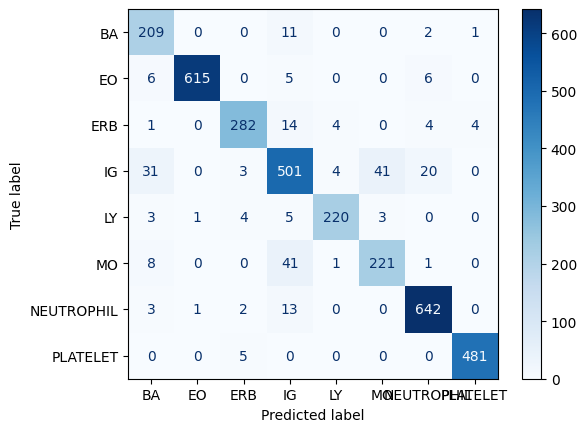


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

          BA       0.80      0.94      0.86       223
          EO       1.00      0.97      0.98       632
         ERB       0.95      0.91      0.93       309
          IG       0.85      0.83      0.84       600
          LY       0.96      0.93      0.95       236
          MO       0.83      0.81      0.82       272
  NEUTROPHIL       0.95      0.97      0.96       661
    PLATELET       0.99      0.99      0.99       486

    accuracy                           0.93      3419
   macro avg       0.92      0.92      0.92      3419
weighted avg       0.93      0.93      0.93      3419



In [38]:
plot_matrix(y_true = test_set, y_pred = y_pred_benchmark_images_masquees,label =label_map)

### **Intégration des résultats au dataframe de synthèse 'resultat_df'**

In [39]:
resultat_df=ajout_dataframe(nom_model = 'model_benchmark_images_masquees', y_true = test_set, y_pred = y_pred_benchmark_images_masquees, num_params = 16613544, dataframe = resultat_df)

<ipython-input-9-d8eadf42cf35>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(result_model, ignore_index=True)


## **2.5. Modèle VGG16 images masquées**

### **Chargement des données**

Déjà chargée dans la partie 1. pour la création du dataframe df_fusion pour définir les chemins d'accès à l'ensemble des images

### **Génération des données d'entrainement et de test**

In [40]:
datagen_train = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = 1./255)

batch_size = 32
height  = 224 # taille adaptée à VGG16
width = 224
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False)



nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples

label_map = train_set.class_indices

print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 8751 validated image filenames belonging to 8 classes.
Found 2187 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 8751 images appartenant à 8 classes
le dataframe validation est composé de 2187 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


### **Chargement du modèle**

In [41]:
#Chargement du modèle VGG16 images masquées
model_vgg16_images_masquees = tf.keras.models.load_model('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_VGG16_images_masquees.h5')

### **Prédictions sur le jeu test**

In [42]:
#Prediction VGG16
pred_vgg16_images_masquees = model_vgg16_images_masquees.predict(test_set)
y_pred_vgg16_images_masquees = tf.argmax(pred_vgg16_images_masquees, axis = 1)

107/107 [==============================] - 20s 146ms/step


### **Matrice de confusion**

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

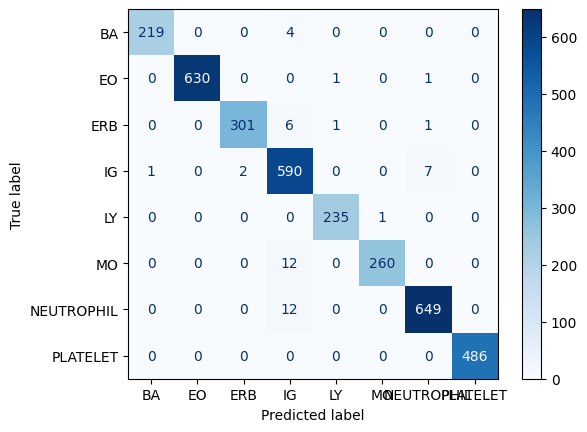


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

          BA       1.00      0.98      0.99       223
          EO       1.00      1.00      1.00       632
         ERB       0.99      0.97      0.98       309
          IG       0.95      0.98      0.96       600
          LY       0.99      1.00      0.99       236
          MO       1.00      0.96      0.98       272
  NEUTROPHIL       0.99      0.98      0.98       661
    PLATELET       1.00      1.00      1.00       486

    accuracy                           0.99      3419
   macro avg       0.99      0.98      0.99      3419
weighted avg       0.99      0.99      0.99      3419



In [43]:
plot_matrix(y_true = test_set, y_pred = y_pred_vgg16_images_masquees,label =label_map)

### **Intégration des résultats au dataframe de synthèse 'resultat_df'**

In [44]:
resultat_df=ajout_dataframe(nom_model = 'model_vgg16_images_masquees', y_true = test_set, y_pred = y_pred_vgg16_images_masquees, num_params = 16613544, dataframe = resultat_df)

<ipython-input-9-d8eadf42cf35>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(result_model, ignore_index=True)


# **3. Synthèse des résultats**

In [48]:
resultat_df

,Model Name,Number of Params,Accuracy,Recall,Precision,F1_score
0,model_benchmark_images_brutes,16613544,[0.9491],[0.9457],[0.942],[0.9432]
1,model_benchmark_images_egalisees,16613544,[0.9105],[0.8766],[0.9202],[0.8903]
2,model_benchmark_egalisation_adaptative,16613544,[0.9193],[0.9236],[0.9067],[0.9103]
3,model_benchmark_images_masquees,16613544,[0.9275],[0.9205],[0.9169],[0.9178]
4,model_vgg16_images_masquees,16613544,[0.9857],[0.9837],[0.9886],[0.986]
